In [1]:
%cd /content/drive/MyDrive/AIFFEL
!pwd

/content/drive/MyDrive/AIFFEL
/content/drive/MyDrive/AIFFEL


In [2]:
!mkdir -p work/camera_sticker/models
!mkdir -p work/camera_sticker/images

In [3]:
!pip install cmake
!pip install opencv-python
!pip install dlib

In [4]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 work/camera_sticker/models
%cd work/camera_sticker
!bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2
%cd ../../

--2025-10-21 23:31:28--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-10-21 23:31:28--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  12.6MB/s    in 6.5s    

2025-10-21 23:31:36 (9.47 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

/content/drive/MyDrive/AIFFEL/work/camera_sticker
bzip2: Output file ./models/shape_predictor_68_face_landmarks.dat already exists.
/content/drive/MyDrive/AIFFEL


In [5]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리

In [6]:
"""
==========================================================
apply_cat_whiskers() 함수 설명
==========================================================
기능(Function)
    입력된 얼굴 이미지에 '고양이 수염(cat whiskers)' 스티커를 자동으로 합성한다.
    얼굴 위치는 dlib의 얼굴 검출기와 68개 얼굴 랜드마크 예측기를 통해 결정된다.

입력(Input)
    - image_path (str): 합성할 원본 이미지 경로
    - face_index (int | None): 여러 얼굴 중 몇 번째 얼굴에 스티커를 적용할지 지정 (None이면 가장 큰 얼굴)
    - white_thresh (int): 배경을 흰색으로 간주할 밝기 기준 (스티커가 알파채널 없을 때 사용)
    - blend_fg (float): 스티커 이미지(전경)의 가중치 (0~1)
    - blend_bg (float): 원본 얼굴 이미지(배경)의 가중치 (0~1)
    - show (bool): 합성된 이미지를 화면에 표시할지 여부
    - output_path (str | None): 결과 이미지를 저장할 경로 (None이면 저장 안 함)

출력(Output)
    - 반환값: None (이미지를 화면에 표시하거나 파일로 저장)
    - 부수효과: 스티커가 적용된 이미지가 생성되어 표시/저장된다.
==========================================================
"""

def apply_cat_whiskers(
    image_path: str,
    face_index: int | None = None,
    white_thresh: int = 240,
    blend_fg: float = 0.7,
    blend_bg: float = 0.3,
    show: bool = True,
    output_path: str | None = None
):

    # ----------------------------------------------------------
    # 1️. 파일 및 모델 경로 설정
    # ----------------------------------------------------------
    CAT_STICKER_PATH = 'work/camera_sticker/images/cat-whiskers.png'
    LANDMARK_PREDICTOR_PATH = 'work/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

    # ----------------------------------------------------------
    # 2️. 이미지 및 스티커 불러오기
    # ----------------------------------------------------------
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"이미지를 불러오지 못했습니다: {image_path}")

    sticker_raw = cv2.imread(CAT_STICKER_PATH, cv2.IMREAD_UNCHANGED)
    if sticker_raw is None:
        raise FileNotFoundError(f"스티커를 불러오지 못했습니다: {CAT_STICKER_PATH}")

    # ----------------------------------------------------------
    # 3️. 얼굴 탐지 및 랜드마크 모델 로드
    # ----------------------------------------------------------
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(LANDMARK_PREDICTOR_PATH)

    # dlib은 RGB 입력을 사용 → BGR → RGB 변환
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 얼굴 탐지 (1은 업샘플링 횟수)
    rects = detector(img_rgb, 1)
    if len(rects) == 0:
        print(f"{image_path}에서 얼굴을 찾지 못했습니다.")
        return

    # ----------------------------------------------------------
    # 4️. 얼굴 선택 로직
    # ----------------------------------------------------------
    if face_index is None:
        # 여러 얼굴 중 가장 큰 얼굴(넓이 기준)을 선택
        areas = [(r.right()-r.left())*(r.bottom()-r.top()) for r in rects]
        idx = int(np.argmax(areas))
    else:
        idx = face_index
        if not (0 <= idx < len(rects)):
            raise IndexError(f"face_index={face_index}, 검출 얼굴 수={len(rects)}")

    # 선택된 얼굴 사각형
    drect = rects[idx]

    # ----------------------------------------------------------
    # 5️. 얼굴 랜드마크 추출 (68개 포인트)
    # ----------------------------------------------------------
    lm = [(p.x, p.y) for p in predictor(img_rgb, drect).parts()]

    # 코 중심 근처 좌표를 기준으로 수염의 중심 위치 계산
    x1 = lm[33][0]; x2 = lm[30][0]
    y1 = lm[33][1] - drect.height()//2
    y2 = lm[30][1] - drect.height()//2
    x = (x1 + x2) // 2
    y = (y1 + y2) // 2
    w = h = drect.width()  # 얼굴 폭 기준으로 스티커 크기 설정

    refined_x = x - w // 2
    refined_y = y

    # ----------------------------------------------------------
    # 6️. 스티커 크기 조정 및 위치 보정
    # ----------------------------------------------------------
    sticker = cv2.resize(sticker_raw, (w, h), interpolation=cv2.INTER_AREA)

    # 이미지 범위를 벗어나면 스티커 잘라내기
    if refined_x < 0:
        sticker = sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        sticker = sticker[-refined_y:, :]
        refined_y = 0

    # ROI(관심 영역) 좌표 계산
    y1, y2 = refined_y, refined_y + sticker.shape[0]
    x1, x2 = refined_x, refined_x + sticker.shape[1]
    H, W = img_bgr.shape[:2]
    y1, x1 = max(0, y1), max(0, x1)
    y2, x2 = min(H, y2), min(W, x2)
    if y1 >= y2 or x1 >= x2:
        raise ValueError("ROI가 화면 밖입니다.")

    # ROI 복사
    roi = img_bgr[y1:y2, x1:x2].copy()

    # ROI 크기에 맞게 스티커 재조정
    sticker = cv2.resize(sticker, (roi.shape[1], roi.shape[0]), interpolation=cv2.INTER_AREA)

    # ----------------------------------------------------------
    # 7️. 스티커 마스크 생성 (알파 채널 or 흰색 배경 기준)
    # ----------------------------------------------------------
    if sticker.shape[2] == 4:
        # RGBA → 알파 채널 사용
        alpha_raw = sticker[:, :, 3]
        fg_mask = alpha_raw
        sticker_bgr = sticker[:, :, :3]
    else:
        # 알파 채널이 없을 경우 흰색 배경 제거
        sticker_bgr = sticker
        bg_mask = cv2.inRange(sticker_bgr, (white_thresh,)*3, (255,)*3)
        fg_mask = cv2.bitwise_not(bg_mask)

    # 마스크 정제 (노이즈 제거 + 부드러운 가장자리)
    kernel = np.ones((3,3), np.uint8)
    fg_mask = cv2.erode(fg_mask, kernel, iterations=1)
    fg_mask = cv2.GaussianBlur(fg_mask, (3,3), 0)

    # ----------------------------------------------------------
    # 8️. 블렌딩 (스티커 + 얼굴 영역)
    # ----------------------------------------------------------
    blended = cv2.addWeighted(roi, blend_bg, sticker_bgr, blend_fg, 0)
    alpha = (fg_mask.astype(np.float32) / 255.0)[:, :, None]

    # 알파 마스크 기반 합성
    out = (alpha * blended.astype(np.float32) + (1 - alpha) * roi.astype(np.float32)).astype(np.uint8)

    # ----------------------------------------------------------
    # 9️. 결과 이미지 생성
    # ----------------------------------------------------------
    result = img_bgr.copy()
    result[y1:y2, x1:x2] = out

    # ----------------------------------------------------------
    # 10. 결과 저장 및 출력
    # ----------------------------------------------------------
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, result)

    if show:
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    return None


Feynman1.jpg


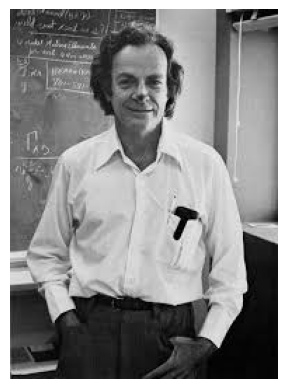

Feynman2.jpg


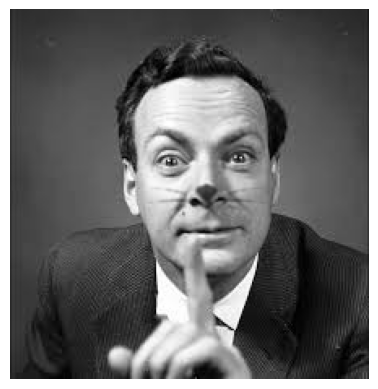

Feynman3.jpg


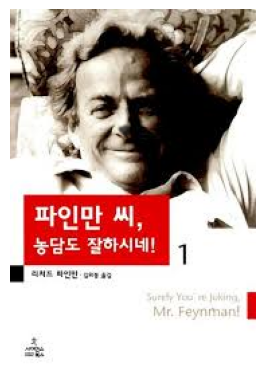

Feynman4.jpg


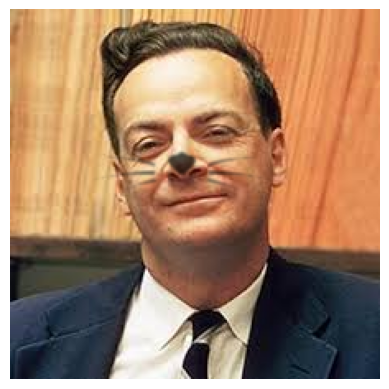

Feynman5.jpg


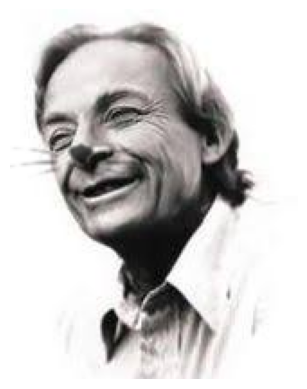

Feynman6.jpg
work/camera_sticker/images/Feynman6.jpg에서 얼굴을 찾지 못했습니다.
Feynman7.jpg


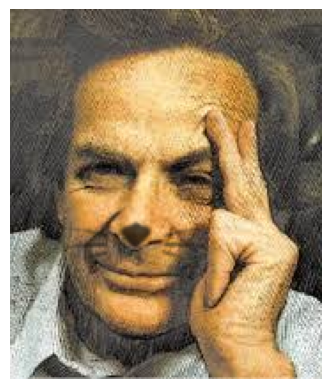

In [7]:
img_path_base = image_path='work/camera_sticker/images/Feynman'

for i in range(1, 8):
    img_path = img_path_base + str(i) + '.jpg'
    print(f"Feynman{i}.jpg")
    apply_cat_whiskers(
        image_path=img_path,
        output_path='work/camera_sticker/output/result/Feynman' + str(i) + '.png'
    )

# 카메라 스티커 앱의 예상되는 문제점
- 얼굴 각도
    - 누워서 촬영한 경우
    - 카메라를 아래에 두고 위쪽으로 촬영한 경우
    - 옆 얼굴을 촬영한 경우
- 이미지 밝기
    - 너무 밝은 경우
    - 너무 어두운 경우
- 촬영 거리
    - 너무 가까워 얼굴을 알아볼 수 없는 경우
        - 요즘 MZ 샷이라고 하면서 눈 위에 카메라 대고 찍는 사진
    - 너무 멀어 얼굴인식이 잘 안되는 경우
- 이미지 화질
    - 이미지가 흔들려서 얼굴이 제대로 나오지 않은 경우
    - 너무 낮은 화질의 이미지를 사용하는 경우
    - 너무 오래되고 빛 바랜 사진을 사용하는 경우
    - 필터를 사용하여 사진의 색이 비슷해 진 경우
    - 이미지 중간에 스크래치가 있는 경우

# 실험 결과 분석
## 이미지별 분석
위에서 예상한 문제들 중 테스트를 진행해 본 경우는 다음과 같다.

1. Feynman1
    - 특징
        - 흑백 이미지
        - 얼굴이 이미지의 10% 이하를 차지하는 경우
    - 결과
        - 흑백 이미지에도 잘 동작하는 것을 확인할 수 있음.
        - 흑백 이미지라서 검은색 스티커가 자연스럽기는 하지만 스티커가 선명하게 보이지는 않음
2. Feynman2
    - 특징
        - 흑백 이미지
        - 얼굴의 일부를 손이 가리는 경우
    - 결과
        - 1번 이미지에 비해 얼굴이 밝게 나와서 조금 더 선명한 스티커의 형태를 확인할 수 있음
        - 극히 일부이긴 하지만 손가락이 얼굴을 가리고 있음에도 문제없이 동작함
3. Feynman3
    - 특징
        - 흑백 이미지
        - 얼굴에 그림자가 심하게 진 경우
    - 결과
        - 얼굴 한 쪽에 그림자가 심하게 져 있어도 얼굴의 형태를 잘 찾아냄
        - 빛 바랜 흑백 이미지의 경우에 스티커가 자연스럽게 녹아들지 못하고 수염이 사라짐
4. Feynman4
    - 특징
        - 컬러
        - 고개가 약간 사선으로 기울어져 있음
    - 결과
        - 수염의 형체가 완벽하게 드러나지는 않음
        - 고개가 살짝 기울어진 정도는 크게 이질적이지 않은 결과를 보임
5. Feynman5
    - 특징
        - 흑백 이미지
        - 카메라가 아래에서 위쪽으로 얼굴을 촬영한 경우
    - 결과
        - 아래에서 위쪽을 촬영하고 있으나 얼굴의 전체적인 특징이 모두 포함되어 있어 인식이 잘 된 것으로 예상됨
        - 흑백 사진이라 고양이 수염 부분이 사라지는 현상 발생
6. Feynman6
    - 특징
        - 흑백 이미지
        - 얼굴이 이미지의 10% 이하를 차지하는 경우
    - 결과
        - 얼굴 인식 자체가 불가능하여 출력 결과도 없음
        - 전체적인 이미지가 어두워서
        - 약 전체 이미지에서 얼굴이 5% 미만으로 차지하고 있음
7. Feynman7
    - 특징
        - 얼굴이 이미지의 80%이상을 차지
        - 얼굴의 일부를 손이 가림
    - 결과
        - 얼굴 한 쪽의 경계가 손으로 가려지긴 했지만 결과가 나쁘지 않게 잘 나왔다.

## 경향 분석
1. 인식 성능
    - 얼굴이 이미지 내에서 10% 이상 비율을 차지할 경우 대부분 안정적으로 인식됨.
    - 얼굴이 5% 이하일 경우 (Feynman6), dlib 얼굴 탐지기의 한계로 인해 인식 실패.
    - 손이나 그림자에 의한 가림에는 비교적 강건함(Feynman2, Feynman3, Feynman7).

2. 스티커 시각 품질
    - 컬러 이미지(Feynman4,7)에서는 자연스러운 블렌딩이 이루어짐.
    - 흑백 이미지(Feynman1,2,3,5,6)의 경우 스티커의 검은 선이 배경과 섞여 수염이 흐릿하거나 사라짐.
    - 명암이 약한 고해상도 흑백 사진일수록 스티커 가시성이 낮아짐.

3. 조명 및 명암 대비
    - 그림자나 조명 불균형이 심해도 (Feynman3) 얼굴 윤곽을 비교적 정확히 탐지함.
    - 그러나 어두운 배경이나 빛바랜 흑백 톤에서는 스티커의 알파 블렌딩 결과가 불균일.

4. 얼굴 기울기/각도
    - 약간의 회전(Feynman4)이나 사선 각도에서는 정상 작동.
    - 상하 방향 각도(Feynman5)에서도 얼굴 윤곽이 유지되면 인식 정확도에 큰 영향 없음.

# 결과
본 실험을 통해 apply_cat_whiskers() 함수는 얼굴이 명확히 인식 가능한 조건(밝기 확보, 10% 이상 비율, 적당한 각도)에서는
흑백/컬러 모두 안정적으로 동작함을 확인하였다.  
그러나 어두운 흑백 이미지나 얼굴이 너무 작은 경우 탐지 실패 또는 스티커의 시각적 불명확성이 발생하였다.  
향후 대비 조정, 회전 보정, 고해상도 대응 탐지기 적용을 통해 정확도 및 시각 품질을 개선할 수 있을 것으로 판단된다.